In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plaid.denoisers.modules import LabelEmbedder, DiTTimestepEmbedder, FourierTimestepEmbedder

In [37]:
import torch
C = 64
t = torch.arange(0,1000).long()

In [38]:
sinusoidal = DiTTimestepEmbedder(C)
sin_emb = sinusoidal.timestep_embedding(t, C)

In [39]:
fourier = FourierTimestepEmbedder(C)
fourier_emb = fourier.timestep_embedding(t, C)

Text(50.722222222222214, 0.5, 'Channel Dimension')

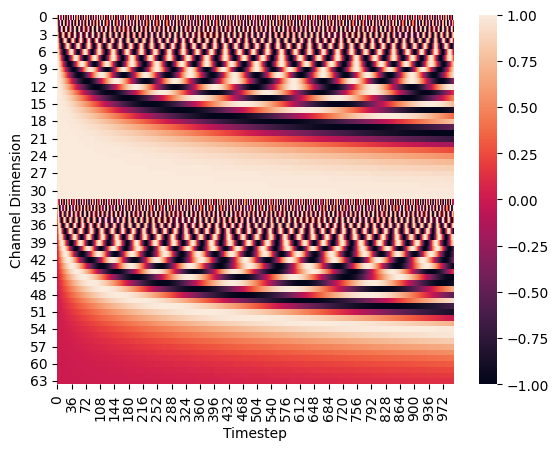

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(sin_emb.T)
plt.xlabel("Timestep")
plt.ylabel("Channel Dimension")

<Axes: >

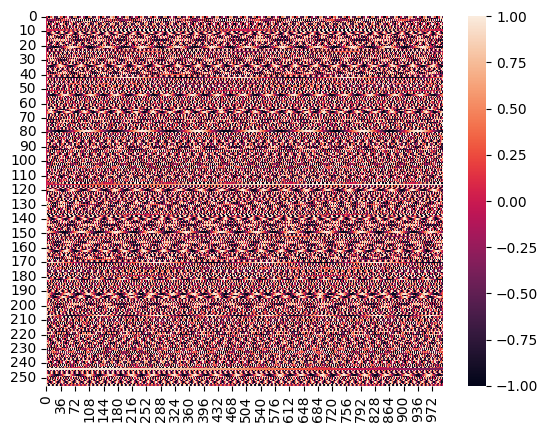

In [44]:
sns.heatmap(fourier_emb.T)

In [50]:
from plaid.denoisers.modules import get_1d_sincos_pos_embed

pos = torch.arange(512)
pos_emb = get_1d_sincos_pos_embed(C, pos)

Text(50.722222222222214, 0.5, 'Channel dimension')

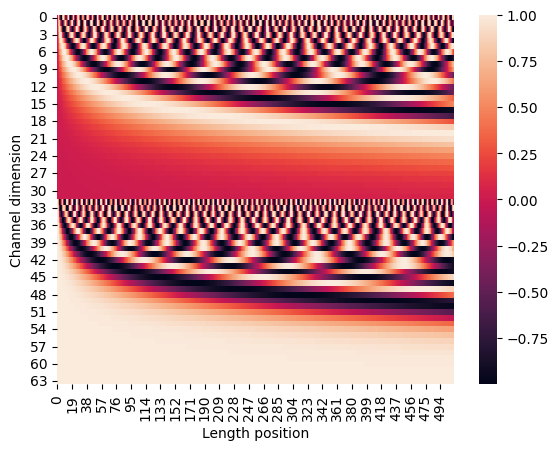

In [51]:
sns.heatmap(pos_emb.T)
plt.xlabel("Length position")
plt.ylabel("Channel dimension")